# Tutorial 3: Perform sentiment analysis using machine learning

## Introduction

In this tutorial you will use a labelled dataset (similar to that used in tutorial 2) to train a machine learning model, which can then be used to make sentiment predictions for new text. We will explore methods of supervised machine learning, as well as a more advanced form of machine learning, called transfer learning.

It is likely that most of you will have come across the term machine learning, but what exactly is machine learning? Machine learning is an application of artificial intelligence (AI), which involves creating computer programmes that take in data and use it to learn the properties/features of the data, in order to make predictions for new data. Rather than explicitly programming rules to predict results, a machine learning model will be able to predict an output from looking at many examples of your data .

The sections of this tutorial are as follows:

1. Classical machine learning \
    1.1 Data preparation \
    1.2 Feature extraction \
    1.3 Building a model   \
    1.4 Make new predictions
    
2. Transfer learning   \
    2.1 BERT   \
    2.2 COVID-Twitter BERT (CT-BERT)


<hr>

## 1. Classical Machine Learning Approach

### Supervised Machine Learning

Classical machine learning is comprised largely of two types of machine learning, namely supervised and unsupervised. 

Supervised machine learning refers to the case where **labelled data** is used to train a model based on the features of each class, in our case it is able to learn which words (features) are most likely to signify a specific sentiment (classes).

As ususal, let's start by importing all the libraries needed for this tutorial.

In [ ]:
# ___Cell no. 1___

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report 

Let's read in the labelled Twitter data, which has been cleaned and undergone preprocessing as demonstrated in tutorial 1, and once again put it into a pandas dataframe. Remember that if these tweets do not sound grammatically correct, it is because the stopwords have been removed from the text.

In [ ]:
# ___Cell no. 2___

df = pd.read_csv('labelled_data_preprocessed.csv')
df

### 1.1 Data Preparation

Let's have a quick look at some of the properties of the data in the dataframe.

In [ ]:
# ___Cell no. 3___

# Display some useful information about the data in the dataframe
df.info()

You may notice that there is a difference in the number of _non-null_ data entries in the 'tweet_text' and 'label' columns.

A common obstacle in the field of data science is the occurence of _bad_ or _missing_ data. In most of these cases, the solution would be to either delete the rows containing the missing data, or to replace the data points with an average of the existing data. 

In our case, we may have missing data in our 'tweet_text' column, due to the stopword removal performed during the data preprocessing. i.e. if there existed any tweets consisting only of stopwords, these will now be empty. We will perform the simple procedure of dropping any rows in which there are missing data in either column. 

In [ ]:
# ___Cell no. 4___

# Drop all rows which contain a NaN, or null value in either column
df = df.dropna()

If we once again display the dataframe info, the number of data entries for each column should now be the same.

In [ ]:
# ___Cell no. 5___

df.info()

Now let's have a quick look at the sentiment label distribution of our data, remembering that the labels 0, 1 and 2 correspond to tweets with negative, neutral and positive sentiment, respectively.

In [ ]:
# ___Cell no. 6___

df['label'].value_counts()

For simplicity sake, we will exclude tweets with neutral sentiment, thus making this a binary classification task. Let's put all tweets with positive and negative sentiment into a new dataframe.

In [ ]:
# ___Cell no. 7___

# make it binary classification challenge
binary_df = df[(df['label']==0) | (df['label']==2) ] 

Next, to make this project and the results more intuitive, let us change the label for positive sentiment from 2 to 1. Thus we will now have a dataframe with the tweet text and a label of either 0 or 1, corresponding to tweets with either a negative or positive sentiment, respectively.

<div class="alert alert-block alert-info">
    
<b>Note:</b> We can ignore the warning text that appears in the red output cell, this is just a warning that occurs when one tries to reset values in the dataframe.

</div>

In [ ]:
# ___Cell no. 8___

# Change the label for positive sentiment from 2 to 1
binary_df['label'] = binary_df['label'].replace(2, 1) 

In [ ]:
# ___Cell no. 9___

binary_df['label'].value_counts()

We can see that there are far more data with negative sentiment labels than positive. This means that our model will likely be better at predicting negative sentiments than positive sentiments. One way to remedy this is to use a balanced dataset so that our prediction model is not biased toward a particular class. We will therefore need to use the same number of negative tweets as positive tweets. Let's do this by randomly selecting the same number of negative tweets and creating a new dataframe.

In [ ]:
# ___Cell no. 10___

# Sample from the dataframe to create a balanced dataset, i.e. address under/over representation of labels
pos_samples = binary_df[binary_df['label']==1]

# Randomly sample from the negative tweets to select the same quantity as the number of psotive tweets
neg_samples = binary_df[binary_df['label']==0].sample(len(pos_samples), random_state=42)

# Put this balanced data into a new dataframe
balanced_binary_df = pd.concat([pos_samples, neg_samples])

Let's make sure that we now have a balanced dataset with equal representation of each class of tweets, i.e. postive and negative sentiment.

In [ ]:
# ___Cell no. 11___

balanced_binary_df['label'].value_counts()

### 1.2 Feature Extraction

Now that we are sure that our dataset contains no missing entries and we have ensured that we are working with a balanced dataset, we can begin to extract features from our data which will be used to train and validate our model.

When working with text (NLP),we will have to first represent our data (tweet text) in a form which a computer would understand...numbers! In other words, we want to _numericalise_ our text. A common way of doing this is called _vectorisation_, but more on this complicated sounding word soon. First, the text needs to be tokenised. Tokenisation simply refers to splitting all text in our corpus into individual words, or, _tokens_.

In [ ]:
# ___Cell no. 12___

tweets = balanced_binary_df['tweet_text']
sentiments = balanced_binary_df['label']
#tweets = binary_df['tweet_text']
#sentiments = binary_df['label']

An 80/20 training/validation split is a good rule of thumb. You want to have as much data as possible to learn from while still having a reliable enough amount of data to evaluate (validate) your model. The more data you have for your model to learn from, the better your chances are of more accurate predictions on unseen data. If we were to use a training set that was too small, the model would learn the specifics of the smaller dataset. This split also depends on the amount of data you have. If you have a very large dataset, you may not need as big of a fraction allocated to the test set. 

*NB  : You may want to play around with this ratio for your own datasets in the future*

In [ ]:
# ___Cell no. 13___

# Randomly splits the data and respective labels (y values) into a train and validation set, the size of the
# validation set is specified to be 20%

X_train, X_test, y_train, y_test  = train_test_split(tweets, sentiments, test_size=0.2, random_state=42)

To begin extracting the features from our text, we are going to make use of the _Bag of Words_ (BOW) method. The BOW approach is simple - Given any text, create a dictionary of each unique word in the text, i.e. the vocabulary, and then count the frequency of each word, i.e. how many times the word is present in the corpus.

(NB: Stop word removal is necessary here so that our vocabulary is made up only of words which contribute to the sentiment of the text)

Let's look at a simple example. Take the tweet "This day is a beautiful sunny day", after removing stop words our text would look something like "day beautiful sunny day". If we now list each unique word and the frequency of each word it would look like this:

| day | beautiful | sunny |
| --- | --- | --- |
| 2 | 1 | 1 |

Once this is done for the entire corpus, the result would be a matrix of the frequency of each word in each document (each tweet in our case). This is called a _**term-document matrix**_ and an example of what this may look like for our COVID19-related tweets is shown in the table below. These numbers, along with zeros for every other word in the dictionary that was not present in this text, will be the _vector_ representation of the tweet text. We therefore call this process _vectorisation_. These vectors are our features which will be used to train and validate our model. Thankfully, the sklearn library makes this process very easy with their implementation of the BOW method called _CountVectorizer_.


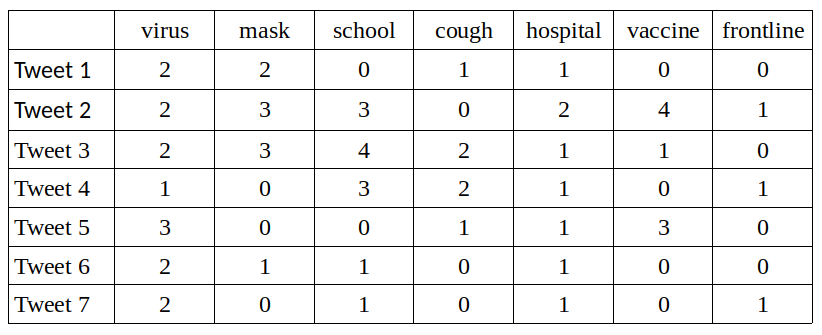

In [ ]:
# ___Cell no. 14___

cv = CountVectorizer(analyzer='word', ngram_range=(1,2)) 

# Builds BOW features on tweets in the train set
# Fit identifies all the unique words in the corpus, while transform counts the occurence of each word 
cv_train_features = cv.fit_transform(X_train) 

The _Ngram_ parameter above refers to searching the text for the most frequent word combinations of size n. Thus, our selection of (1,2) means that tokens will comprise of unique words, as well as common ngrams of size 2 (also known as bi-grams), for example, 'new_york', 'infection_rate' etc.

In [ ]:
# ___Cell no. 15___

# Obtain the features for the test set
cv_test_features = cv.transform(X_test)

### 1.3 Build A Classification Model

Researchers and data scientists have, over time, created many different machine learning models, some of which are well-known and used often. Some models are more suited to certain problems, i.e. computer vision (image processing), NLP (text), numerical data etc. These models differ in the way that they _learn_.

With the existence of amazing libraries such as [scikit-learn](https://scikit-learn.org/stable/), we are able to easily access and try out various models, to see which yield the best results. The end goal is for our model to be able to classify text as having either positive or negative sentiment, thus, we will try out various _classifier_ models.

If you wish to learn more about the various models on offer from scikit-learn you can read up on them [here](https://scikit-learn.org/stable/supervised_learning.html).

In [ ]:
# ___Cell no. 16___

# Here we instantiate the various models

# Support vector machine model
svm = SGDClassifier(loss='hinge', l1_ratio=0.15, max_iter=300, n_jobs=4, random_state=101)
# Decision tree model
dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
# Random forest model
rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
# Logistic regression model
lr = LogisticRegression(max_iter=100, C=1, multi_class='auto', solver='lbfgs')
# Kernel svm model
kernel_svm = SVC(kernel = 'rbf', random_state = 0, gamma='scale')
# K nearest neighbours model
knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

Let's select a classifier model from the options above.

In [ ]:
# ___Cell no. 17___

# Select which classifier model you want to use
classifier =  dt

Below we create a function which uses the selected classifier, along with the features of the train set to train the model. The model is then used to make predictions about the data in the validation set.

In [ ]:
# ___Cell no. 18___

def train_predict_model(classifier,  train_features, train_labels,  test_features, test_labels):
    
    # build the model    
    classifier.fit(train_features, train_labels)
    # make predictions using model
    y_pred = classifier.predict(test_features) 
    
    return y_pred

We then call the above function, passing in the chosen classifier, features of the training and validation set extracted using CountVectorizer, as well as the corresponding sentiment labels. 

In summary, the model learns from the features of the tweets in the training set and their respective training labels, and, given the features of the tweets in the validation set, attempts to predict the class labels of tweets in the validation set.

In [ ]:
# ___Cell no. 19___

# Model predictions

y_pred = train_predict_model(classifier=classifier,
                             train_features=cv_train_features,
                             train_labels= y_train,
                             test_features=cv_test_features,
                             test_labels= y_test)

There are various metrics which then provide information on the performance of our model. Scikit-learn has [methods](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) which easily calculate these metrics for us. The metrics we will be using are the confusion matrix, f1 score, accuracy, as well as a convenient classification report which provides more detailed information such as the precison, recall and f1 score for each class.

Below is a brief description of each metric:

- **Accuracy** - This represents the number of correct classifications (true positives + true negatives) over the total number of classifications made.
- **Precision** - This metric quantifies the number of positive class predictions that actually belong to the positive class.
- **Recall** - Recall quantifies the number of positive class predictions made out of all positive examples (true positives + false negatives) in the dataset.
- **F1-score** (also called the F-Measure) - This metric balances the concerns of both precision and recall and is therefore a more reliable measure of performance.

A more detailed explanation of the above metrics can be found in this [article](https://medium.com/analytics-vidhya/confusion-matrix-accuracy-precision-recall-f1-score-ade299cf63cd).

In [ ]:
# ___Cell no. 20___

# To calculate these metrics we pass in the actual sentiment labels for tweets in the validation set (y_test),
# along with the sentiment predictions from our model (y_pred)
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# Print out the results
print('Confusion Matrix:', '\n')
print(cm, '\n')
print('Accuracy = ', accuracy)
print('F1 Score = ',f1, '\n')
print(classification_report(y_test, y_pred))

Take note of the f1-score for each class, i.e. tweets with negative (0) and positive (1) sentiment. Investigate what happens if the unbalanced dataset (_binary_df_ - see cell number 12) is used to train the model, how does it impact the f1-scores?

### 1.4 Make new predictions

The _classifier_ model which you have trained in the section above can now be used to predict the sentiment for new/unseen text, i.e. the tweets which you will collect when working on the hackathon task.

After collecting, cleaning and pre-processing your tweets, you will extract the features of the tweet text using Count Vectorizer as you have done in the section above. You will then pass in the features of your tweet text into the model**.predict** function as shown below.

In [ ]:
# ___Cell no. 21___

# The text from your new tweets - here we are just using a small subset of the exisiting tweet_text column
# for demonstration purposes.

new_tweets = df['tweet_text'].iloc[10:30]

In [ ]:
# ___Cell no. 22___

# Extract the features of the twitter text you have collected
newtext_features = cv.transform(new_tweets)

In [ ]:
# ___Cell no. 23___

# Obtain the model's sentiment predictions for your collected tweets
new_result = classifier.predict(newtext_features)
print(new_result)

The function outputs an array of sentiment predictions corresponding to each tweet, i.e. 0 - negative sentiment and 1 - positive sentiment.

<hr>

## 2. Transfer Learning Approach

A subset of machine learning is called _deep learning_. Deep learning makes use of deep neural networks, i.e. neutral networks which have an input layer, output layer and one or more _hidden layers_ in between, in order to train a prediction model.

As useful and impressive as deep learning models are, they usually require LOTS of data. This is especially true for NLP where we may be able to train our model based on text features corresponding to a certain sentiment, however our model may lack an understanding of the nuances of language. Language is inherently a difficult concept for a computer to grasp. We would therefore benefit from a model which has been trained on a very large, generalised dataset, which we could then fine-tune to our specific needs. The ability to transfer knowledge from a trained model is known as _transfer learning_ and is the method we will be exploring.

Transfer learning is thus a concept where you take knowledge gained from one problem and apply it to a similar problem. In as far as it applies to our use case of predicting sentiment, transfer learning can be distilled into three steps:

1) Use an existing language model that has been trained on LOTS (usually 10s or 100s of GB worth) of text. This will result in a language model that 'understands' the rules of a language. This is referred to as a pretrained language model.

2) The next step is fine-tuning. This is where we take a language model that 'understands' language in a more general sense and adapt it to our particular domain. This could be, for example, medical reports, legislative documents or as in the case of our work, Covid-19 related tweets.

3) Once we have a fine-tuned language model we can then use it to initialise a classifier to predict the labels of our domain specific text, i.e. sentiment.

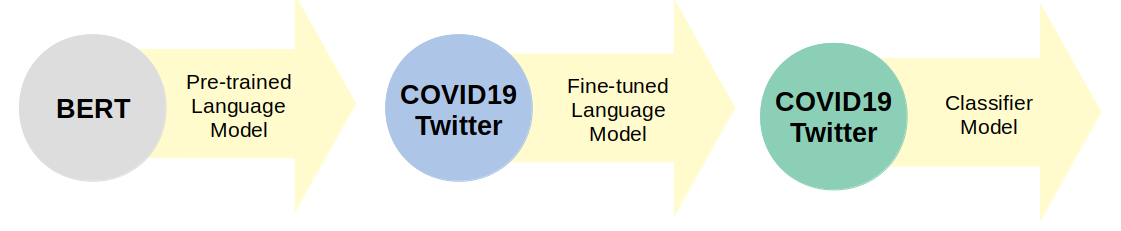

In [ ]:
# ___Cell no. 24___

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# ___Cell no. 25___

from simpletransformers.classification import ClassificationModel

import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import random
import numpy as np
import torch
from sklearn.model_selection import KFold

import logging
from pathlib import Path

Unlike in the supervised learning approach above, in the case of transfer learning, we want to work with text which has not had stopwords removed. This is because we want our text to be representative of normal language and possess the same language structure and rules as learned by the language model we will use.

In [ ]:
# ___Cell no. 26___

df2 = pd.read_csv('labelled_data_cleaned.csv')
df2

Now let's create the binary and balanced versions of the dataset, as we did in the supervised learning example above.

<div class="alert alert-block alert-info">
    
<b>Note:</b> We can once again ignore the warning text that appears in the red output cell, this is just a warning that occurs when one tries to reset values in the dataframe.

</div>

In [ ]:
# ___Cell no. 27___

bi_df = df2[(df2.label==0) | (df2.label==2) ] # make it binary classification
bi_df.label.replace(2,1, inplace=True) # make it binary classification

pos_samples = bi_df[bi_df['label']==1]
neg_samples = bi_df[bi_df['label']==0].sample(len(pos_samples), random_state=42)

bal_bi_df = pd.concat([pos_samples, neg_samples])

bi_df['label'].value_counts()
bal_bi_df['label'].value_counts()

Let's start by using the binary, balanced dataset as in the supervised machine learning example.

Now let's randomly split the data into the training and validation set, specifying the 80%-20% split.

In [ ]:
# ___Cell no. 28___

train_df, val_df = train_test_split(bi_df, test_size=0.2,  random_state=42)

Let's have a look at the number of tweets we have, for each class (sentiment) in the training and validation set.

In [ ]:
# ___Cell no. 29___

train_df['label'].value_counts()
val_df['label'].value_counts()

### 2.2 Using BERT

<div class="alert alert-block alert-warning">

<b>!! Attention !!</b> You MUST get permission from a tutor before running the cells below. Please alert a tutor once you are ready to run the cells to train the BERT and CT-BERT models.

</div>

BERT is a powerful language model in transfer learning and stands for "**B**idirectional **E**ncoder **R**epresentations from **T**ransformers". One of the advantages of BERT is that it reads words in both directions (bidirectionally) and can therefore read words before _and_ after the word in a sequence. The BERT language model is trained on a large amount of text from Wikipedia. You can read more about the BERT language model introduced in this [paper](https://arxiv.org/abs/1810.04805).

The [Simple Transformers library](https://simpletransformers.ai/) is a great tool for quickly and efficiently utilising models for transfer learning. Simple Transformer models are built with a particular Natural Language Processing (NLP) task in mind. Each such model comes equipped with features and functionality designed to best fit the task that they are intended to perform. In our case we will be using the classification model.

Now let's get straight into building and training our domain adapted classifer using the BERT as our pretrained language model. 

<div class="alert alert-block alert-info">
    
<b>Note:</b> Please ignore the warning text that appears in red output cells - these are just guidlines from simpletransformers regarding the BERT model.

</div>

In [ ]:
# ___Cell no. 30___

# Build the model

bert_model = ClassificationModel('bert',
                            'bert-base-cased',
                            num_labels=2,
                            use_cuda=False,
                            args={'overwrite_output_dir': True})

<div class="alert alert-block alert-info">
    
<b>Note:</b> If you have received permission from a tutor, you may now run the next cell to train the BERT model. Note that it should take approximately 4 minutes for the cell to run.

</div>

In [ ]:
%%time

# ___Cell no. 31___

# Train the model 
bert_model.train_model(train_df=train_df, eval_df=val_df)

We now create wrapper functions which will allow us to obtain information about the performance of our model, i.e. the f1 score and "classification report". 

A wrapper function is a simple utility that allows us to modify an existing function (in our case we modify the metrics from **sklearn** so that it can be utilised by **Simple Transformers**). 

In [ ]:
# ___Cell no. 32___

# wrapper functions

def multi_F1(y_true, y_pred, average='macro'):
    return sklearn.metrics.f1_score(y_true=y_true, y_pred=y_pred, average=average)

def multi_classification_report(y_true, y_pred):
    return sklearn.metrics.classification_report(y_true=y_true, y_pred=y_pred)

In [ ]:
%%time

# ___Cell no. 33___

# Calculated and print out the f1 score

result, model_outputs, wrong_predictions = bert_model.eval_model(val_df, f1=multi_F1);
print('f1 score = ',result['f1'])

In [ ]:
%%time

# ___Cell no. 34___

# Calculated and print out the results in the classification report

result, model_outputs, wrong_predictions = bert_model.eval_model(val_df, report=multi_classification_report);
print('Classification Report: ', result['report'])

### Using the BERT model to make sentiment predictions for new data

In order to use your trained BERT classification model to make new sentiment predictions for unseen data, you will follow steps similar to those shown in **Section 1.4**. However, now there is no need for vectorization.

In [ ]:
# ___Cell no. 35___

# The text from your new tweets - here we are just using a small subset of the exisiting tweet_text column
# for demonstration purposes.

new_tweets = df['tweet_text'].iloc[10:30].values

In [ ]:
# ___Cell no. 36___

# Obtain the model's sentiment predictions for your collected tweets

new_result = bert_model.predict(new_tweets)
print(new_result[0])

### 2.2 Using the COVID-Twitter BERT

<div class="alert alert-block alert-warning">

<b>!! Attention !!</b> You MUST get permission from a tutor before running the cells below. Please alert a tutor once you are ready to run the cells to train the BERT and CT-BERT models.

</div>

When describing transfer learning above, we stated that our pretrained language model is trained on LOTS of text and learns the general rules of that language and that this model is then adapted to our domain. 

Luckily for us, researchers from the Digital Epidemiology Lab in Geneva, Switzerland have trained a language model based on a large amount of COVID19-related tweets. Instead of creating a language model that learns about text from articles in Wikipedia, they trained a language model called [CT-BERT](https://arxiv.org/abs/2005.07503) which has the same architecture as BERT, but that only understands the use of language as it pertains to tweets related to Covid-19. Intuitively, we should expect improved results if we use CT-BERT as our pretrained model instead of BERT.

Let's once again specify which version of the dataset we want to use and specify how we'd like the data to be split into the training and validation set.

In [ ]:
# ___Cell no. 37___

train_df, val_df = train_test_split(bi_df, test_size=0.2,  random_state=42)

In [ ]:
# ___Cell no. 38___

train_df['label'].value_counts()
val_df['label'].value_counts()

In [ ]:
# ___Cell no. 40___

# Build the ct-bert model

ct_model = ClassificationModel('bert',
                            'digitalepidemiologylab/covid-twitter-bert',
                            num_labels=2,
                            use_cuda=False,
                            args={'overwrite_output_dir': True})

<div class="alert alert-block alert-info">
    
<b>Note:</b> If you have received permission from a tutor, you may now run the next cell to train the CT-BERT model. Note that it should take approximately 10 minutes for the cell to run.

</div>

In [ ]:
%%time

# ___Cell no. 41___

# Train the ct-bert model

ct_model.train_model(train_df=train_df, eval_df=val_df)

In [ ]:
%%time

# ___Cell no. 42___

# Calculated and print out the f1 score

result, model_outputs, wrong_predictions = ct_model.eval_model(val_df, f1=multi_F1);
print('f1 score = ',result['f1'])

In [ ]:
%%time

# ___Cell no. 43___

# Calculated and print out the results in the classification report

result, model_outputs, wrong_predictions = ct_model.eval_model(val_df, report=multi_classification_report);
print('Classification Report: ', result['report'])

After completing this tutorial you should be able to:

- Identify and resolve the problem of "bad" or "missing" data
- Use Count Vectorizer to implement the BOW method
- Train a classical supervised learning model
- Make use of the BERT languale model for transfer learning
- Obtain new sentiment predictions using any of the trained models

### Tutorial 3 complete! Well done!

### You are now ready to start working on the hackathon task!


Think of a research question where sentiment analysis can be used to gain insight into topics related to COVID19.

For example: What is the sentiment around a government’s response to COVID19, and how does this vary for different countries? Or, what is the sentiment around wearing masks? Perhaps you could investigate people’s sentiment regarding lockdown in various countries or cities.

You will need to

- Collect Twitter data from one or multiple regions in the world, relevant to your research question.
- Prepare the data (by cleaning and/or pre-processing).
- Make use of existing sentiment analysis tools or one of the trained machine learning models to predict sentiment of your collected tweets.
- Draw some conclusions and present your findings.